<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/hyperparameter_search/find_subnets_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Everything

## Imports

In [0]:
import os

if not os.path.isdir('Preference_Extraction'):
    print("Setting up colab environment")
    !pip uninstall -y -q pyarrow
    !pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
    !pip install -q ray[debug]
    !pip install 'ray[tune]' 
    !pip install bayesian-optimization

    !git clone https://github.com/arunraja-hub/Preference_Extraction.git
    # # A hack to force the runtime to restart, needed to include the above dependencies.
    # # Only after first time
    os._exit(0)

In [0]:
## If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import print_function
import argparse
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torch.autograd as autograd
from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import concurrent.futures
import itertools
import os
import random
import sys
import time
import re
import io
import itertools
import sys

import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch

sys.path.append('Preference_Extraction')
from imports_data import all_load_data

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Parameters

In [0]:
params = {
    'num_train': 50,
    'num_tune': 25,
    'num_val': 400,
    'batch_size': 10,
    'val_batch_size': 10,
    'num_epochs': 40,
    'use_qnet_weights': True, # Flag for running models that use the weights of Qnet vs models that use random weights
    'use_mnist': False,  # Flag for running models on MNIST. If False uses RL Preference Extraction data
    'num_run': 5  # Number of runs (with different data sample) over which to average performance
}

## Subnets Methods

In [0]:
"""
    Original code from What's hidden in a randomly weighted neural network? paper
    Implemented at https://github.com/allenai/hidden-networks
    Remove weigths-initialisation since it is not relevant for us
"""

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, k, scores_init='xavier_normal', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.weight)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.weight)
        else:
          nn.init.uniform_(self.weight)

        # initialize the weights
        nn.init.uniform_(self.weight)
        
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

class SupermaskLinear(nn.Linear):
    def __init__(self, *args, k, scores_init='xavier_normal', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores and weights
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.weight)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.weight)
        else:
          nn.init.uniform_(self.weight)

        nn.init.uniform_(self.weight)

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

# NOTE: not used here but we use NON-AFFINE Normalization!
# So there is no learned parameters for your nomralization layer.
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

## Define architecture

In [0]:
class PrefQNet(nn.Module):
    """
      If q_head_index is None, this uses a linear model on the normalized q outputs.
      Otherwise, it gets the Q head with the specified index.
    """ 
    def __init__(self, fine_tune, k, q_head_index, q_means_stds, use_last_linear):
        super(PrefQNet, self).__init__()
        
        if not params['use_mnist']:
            channels_in = 5
            flattened_shape = 960
        else:
            channels_in = 1
            flattened_shape = 4608

        if fine_tune:
            conv_layer = nn.Conv2d
            dense_layer = nn.Linear
            additional_args = {}
        else:
            conv_layer = SupermaskConv
            dense_layer = SupermaskLinear
            additional_args = {'k': k}

        self.conv1 = conv_layer(in_channels=channels_in, out_channels=16, kernel_size=3, stride=1, bias=True, **additional_args)
        self.conv2 = conv_layer(in_channels=16, out_channels=32, kernel_size=3, stride=2, bias=True, **additional_args)
        self.fc1 = dense_layer(in_features=flattened_shape, out_features=64, bias=True, **additional_args)
        self.fc2 = dense_layer(in_features=64, out_features=3, bias=True, **additional_args)
        self.fc3 = dense_layer(in_features=3, out_features=1, bias=True, **additional_args)
        self.linear = nn.Linear(1, 1, bias=True)

        self.qix = q_head_index
        self.qu_mu_s = q_means_stds
        self.use_last_linear = use_last_linear

    def fwd_conv1(self, x):
        x = self.conv1(x)
        return F.relu(x)

    def fwd_conv2(self, x):
        x = self.fwd_conv1(x)
        x = self.conv2(x)
        return F.relu(x)

    def fwd_flat(self, x):
        x = self.fwd_conv2(x)
        return torch.flatten(torch.transpose(x, 1, 3), 1) # Pre-flattening transpose is necessary for TF-Torch conversion

    def fwd_fc1(self, x):
        x = self.fwd_flat(x)
        x = self.fc1(x)
        return F.relu(x)
    
    def fwd_fc2(self, x):
        x = self.fwd_fc1(x)
        return self.fc2(x)

    def forward(self, x):
        x = self.fwd_fc2(x)

        x -= torch.tensor(self.qu_mu_s[0], device=device)
        x /= torch.tensor(self.qu_mu_s[1], device=device)

        if self.qix == None:
          x = self.fc3(x)
        else:
          x = x[: ,self.qix:self.qix+1]

        if self.use_last_linear:
          x = self.linear(x)

        x = torch.sigmoid(x)
        return x.flatten()

## Load Data

In [0]:
# Run this cell for training with original RL Preference Extraction data
if not params['use_mnist']:
    all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

    activations = []
    observations = []
    preferences = []

    for data in all_raw_data:
        for i in range(data.observation.shape[0]):
            observations.append(np.copy(data.observation[i]))
            activations.append(np.copy(data.policy_info["activations"][i]))
            preferences.append((data.policy_info['satisfaction'].as_list()[i] > -6).astype(int))

    activations = np.array(activations)

    xs = np.rollaxis(np.array(observations), 3, 1) # Torch wants channel-first
    ys = np.array(preferences)

In [0]:
# Run this cell for training with MNIST
if params['use_mnist']:
    tr_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=params['batch_size'], shuffle=True)

    val_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist', train=False, download=True, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=params['val_batch_size'], shuffle=True)

## Loading Weights

In [11]:
new_save_path = "Preference_Extraction/saved_model2"
restored_model = tf.keras.models.load_model(new_save_path)
restored_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork/conv2d (Conv (None, 12, 14, 16)        736       
_________________________________________________________________
EncodingNetwork/conv2d_1 (Co (None, 5, 6, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
EncodingNetwork/dense (Dense (None, 64)                61504     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [0]:
original_weights=restored_model.get_weights()

In [0]:
def load_weights(model):
    if not params['use_mnist']:
        model.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0]))
        model.fc1.weight.data = torch.from_numpy(np.transpose(original_weights[4]))
    else:
        model.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0][:,:,:1,:]))
        mnist_flt_weights = np.random.rand(64, 4608)
        mnist_flt_weights[:, :original_weights[4].shape[0]] = np.transpose(original_weights[4])
        mnist_flt_weights = mnist_flt_weights.astype(np.float32)
        model.fc1.weight.data = torch.from_numpy(mnist_flt_weights)

    model.conv1.bias.data = torch.from_numpy(original_weights[1])
    model.conv2.weight.data = torch.from_numpy(np.transpose(original_weights[2]))
    model.conv2.bias.data = torch.from_numpy(original_weights[3])
    model.fc1.bias.data = torch.from_numpy(original_weights[5])
    model.fc2.weight.data = torch.from_numpy(np.transpose(original_weights[6]))
    model.fc2.bias.data = torch.from_numpy(original_weights[7])
    model.fc3.weight.data = torch.from_numpy(np.ones(shape=[1,3], dtype=np.float32))
    model.fc3.bias.data = torch.from_numpy(np.zeros(shape=[1], dtype=np.float32))
    model.to(device)

In [0]:
test_model = PrefQNet(k=1, fine_tune=False, q_head_index=None, q_means_stds=[[0, 0, 0], [1, 1, 1]], use_last_linear=True).to(device)

if params['use_qnet_weights']:
    load_weights(test_model)

## Test the weights loaded properly

In [0]:
# Comparing that the models have identical observations for identical images
tf_conv1_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[0].output)
tf_conv2_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[1].output)
tf_flt_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[2].output)
tf_fc1_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[3].output)

def npsigmoid(x):
  return 1/(1 + np.exp(-x)) 

def check_same(torch_layer, tf_layer):
    torch_out = np.transpose(torch_layer(single_observation_torch).detach().cpu().numpy())
    torch_out = torch_out.reshape(torch_out.shape[:-1])
    tf_out = tf_layer(single_observation)[0].numpy()
    np.testing.assert_allclose(torch_out, tf_out, rtol=.1, atol=5)  

# due to shape of original TF model this test can be done only when use_mnist = False
if not params['use_mnist'] and params['use_qnet_weights']:
    for i in range(len(all_raw_data[0].observation)):

        single_observation = np.array([all_raw_data[0].observation[i]])
        single_observation_torch = torch.Tensor(np.array([np.transpose(all_raw_data[0].observation[i])]))

        single_observation_torch = single_observation_torch.to(device)

        check_same(test_model.fwd_conv1, tf_conv1_fn)
        check_same(test_model.fwd_conv2, tf_conv2_fn)
        check_same(test_model.fwd_flat, tf_flt_fn)
        check_same(test_model.fwd_flat, tf_flt_fn)

        fc1_torch_out = np.transpose(test_model.fwd_fc1(single_observation_torch).detach().cpu().numpy())
        fc1_torch_out = fc1_torch_out.reshape(fc1_torch_out.shape[:-1])
        fc1_tf_out = tf_fc1_fn(single_observation)[0].numpy()
        
        np.testing.assert_allclose(fc1_torch_out, fc1_tf_out, rtol=.1, atol=5)
        old_activations = all_raw_data[0].policy_info["activations"][i]
        np.testing.assert_allclose(fc1_torch_out, old_activations, rtol=.1, atol=5)
        np.testing.assert_allclose(old_activations, fc1_tf_out, rtol=.1, atol=5)

        check_same(test_model.fwd_fc2, restored_model)

        torch_out = np.transpose(test_model.forward(single_observation_torch).detach().cpu().numpy())
        torch_out = torch_out.reshape(torch_out.shape[:-1])
        tf_out = npsigmoid(np.sum(restored_model(single_observation)[0].numpy()))
        np.testing.assert_allclose(torch_out, tf_out, rtol=.1, atol=5)  

## Modelling

### Get data to normalize qHeads

In [16]:
def get_q_heads_mu_and_sigma(model, all_obs, num_obs):
    
    model.eval()

    all_obs = shuffle(all_obs)
    obs_to_pass = all_obs[:num_obs]

    obs_tensor = torch.Tensor(obs_to_pass)
    obs_tensor = obs_tensor.to(device)
    qheads_values = model.fwd_fc2(obs_tensor).detach().cpu().numpy()

    mu = qheads_values.mean(axis=0)
    s = qheads_values.std(axis=0)

    print("mu", mu, "s", s)
    
    return np.array([mu, s])

if params['use_mnist']:
    img_batch, label = iter(tr_data_loader).next()
    xs = img_batch

q_mu_s = get_q_heads_mu_and_sigma(test_model, xs, 10000)

mu [ 92.73059   68.479195 138.51987 ] s [47.61169 51.08191 77.90741]


### Methods to inspect performance

In [0]:
def get_number_of_new_scores_in_top_k(new_scores, old_scores, k):
    new_top_k_scores = set(new_scores[:int(len(new_scores) * k)])
    old_top_k_scores = set(old_scores[:int(len(old_scores) * k)])

    return len(old_top_k_scores) - len(new_top_k_scores.intersection(old_top_k_scores))

def model_scores_to_dict(model):
    return {
        'conv1': model.conv1.scores.detach().cpu().numpy().flatten().argsort(),
        'conv2': model.conv2.scores.detach().cpu().numpy().flatten().argsort(),
        'fc1': model.fc1.scores.detach().cpu().numpy().flatten().argsort(),
        'fc2': model.fc2.scores.detach().cpu().numpy().flatten().argsort(),
        'fc3': model.fc3.scores.detach().cpu().numpy().flatten().argsort()
    }

def get_no_of_changed_scores(model, previous_scores, k):

    new_scores_idxs = model_scores_to_dict(model)

    score_changes = {}

    for score in new_scores_idxs:
        changed_scores_num = get_number_of_new_scores_in_top_k(new_scores_idxs[score], previous_scores[score], k)
        score_changes[score] = changed_scores_num

    return score_changes, new_scores_idxs

def plot_metric(results_dict, metric):
    plt.title(metric)
    plt.xlabel('Epochs')
    plt.plot(list(range(1, params['num_epochs'] + 1)), results_dict[f'train{metric}'], label=f'Train {metric}')
    plt.plot(list(range(1, params['num_epochs'] + 1)), results_dict[f'test{metric}'], label=f'Test {metric}')
    plt.legend()
    plt.show()

def plot_metric_multiple_runs(results_items, metric, train=True):
    plt.title(metric)
    plt.xlabel('Epochs')
    for res_key, res_dict in results_items.items():
        if train:
            plt.plot(list(range(1, params['num_epochs'] + 1)), res_dict[f'train{metric}'], label=f'Train {metric} - {res_key}')
        else:
            plt.plot(list(range(1, params['num_epochs'] + 1)), res_dict[f'test{metric}'], label=f'Test {metric} - {res_key}')
    plt.legend()
    plt.show()

def plot_score_changes(score_changes_dict):
    plt.title('Layer-wise score changes')
    plt.xlabel('Optimisation steps (num_train / batch_size * epochs)')
    for layer in score_changes_dict:
        plt.plot(list(range(1, len(score_changes_dict[layer]) + 1)), score_changes_dict[layer], label=f'{layer}')
    plt.legend()
    plt.show()

### Method to get data for one sample run

In [0]:
def get_data_sample(xs=None, ys=None):

    if not params['use_mnist']:
        xs, ys = shuffle(xs, ys)
        
        train_split = params['num_train']
        tune_split = params['num_train']+params['num_tune']
        test_split = params['num_train']+params['num_tune']+params['num_val']

        tr_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[:train_split]), torch.Tensor(ys[:train_split])),
            batch_size=params['batch_size'])

        tune_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[train_split:tune_split]), torch.Tensor(ys[train_split:tune_split])),
            batch_size=params['batch_size'])

        val_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[tune_split:test_split]), torch.Tensor(ys[tune_split:test_split])),
            batch_size=params['val_batch_size'])
    else:
        tr_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=params['batch_size'], shuffle=True)

        tune_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=False, download=True, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=params['batch_size'], shuffle=True)

        val_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=False, download=True, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=params['val_batch_size'], shuffle=True)
        
    return tr_data_loader, tune_data_loader, val_data_loader

### Single run train/test methods

In [0]:
"""
    Train/Test function for Randomly Weighted Hidden Neural Networks Techniques
    Adapted from https://github.com/NesterukSergey/hidden-networks/blob/master/demos/mnist.ipynb
"""

def metrics(predictions, true_labels):
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.sum(np.equal((predictions > 0.5).astype(int), true_labels)) / len(true_labels)
    auc = roc_auc_score(true_labels, predictions)
    return accuracy, auc

def train(model, k, device, train_loader, optimizer, criterion):
    
    train_loss = 0
    true_labels = []
    predictions = [] # labels

    model.train()
    train_score_changes = {}
    if k is not None:
        scores = model_scores_to_dict(model)
        train_score_changes = {k: [] for k in scores}

    for data, target in itertools.islice(train_loader, params['num_train']):
        
        data, target = data.to(device), target.to(device)
        if params['use_mnist']:
            target = (target > 0).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if k is not None:
            score_changes, scores = get_no_of_changed_scores(model, scores, k)
            for layer_changes in score_changes:
                train_score_changes[layer_changes].append(score_changes[layer_changes])

        train_loss += loss
        predictions.extend(output.detach().cpu().numpy())
        true_labels.extend(target.detach().cpu().numpy())
    
    train_loss /= len(train_loader.dataset)
    accuracy, auc = metrics(predictions, true_labels)

    return train_loss.item(), accuracy, auc, train_score_changes


def test(model, device, criterion, test_loader, num_test):
    true_labels = []
    predictions = [] # labels

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in itertools.islice(test_loader, num_test):
            data, target = data.to(device), target.to(device)
            if params['use_mnist']:
                target = (target > 0).float()
            output = model(data)
            test_loss += criterion(output, target)

            predictions.extend(output.detach().cpu().numpy())
            true_labels.extend(target.detach().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    accuracy, auc = metrics(predictions, true_labels)

    return test_loss.item(), accuracy, auc

def run_model(model, k, learning_rate, weight_decay, num_epochs):

  tr_data_loader, tune_data_loader, val_data_loader = get_data_sample(xs, ys)

  optimizer = optim.Adam(
      [p for p in model.parameters() if p.requires_grad],
      lr=learning_rate,
      weight_decay=weight_decay
      
  )

  criterion = nn.BCELoss().to(device)
  scheduler = CosineAnnealingLR(optimizer, len(tr_data_loader), eta_min=learning_rate)

  train_losses = []
  test_losses = []
  tune_losses = []
  train_accs = []
  train_aucs = []
  test_accs = []
  test_aucs = []
  score_changes = []
  

  for epoch in range(num_epochs):
      train_loss, train_accuracy, train_auc, train_score_changes = train(model, k, device, tr_data_loader, optimizer, criterion)
      tune_loss, _, _ = test(model, device, criterion, tune_data_loader, params['num_tune'])
      test_loss, test_accuracy, test_auc = test(model, device, criterion, val_data_loader, params['num_val'])
      scheduler.step()

      score_changes.append(train_score_changes)
      train_losses.append(train_loss)
      tune_losses.append(tune_loss)
      test_losses.append(test_loss)
      train_accs.append(train_accuracy)
      train_aucs.append(train_auc)
      test_accs.append(test_accuracy)
      test_aucs.append(test_auc)

  merged_score_changes = {k: [] for k in score_changes[0].keys()}
  for d in score_changes:
    for k in d:
        merged_score_changes[k].extend(d[k])

  return {'trainLoss': train_losses, 'testLoss': test_losses, 'tuneLoss': tune_losses,
          'trainAccuracy': train_accs, 'testAccuracy': test_accs,
          'trainAUC': train_aucs, 'testAUC': test_aucs, 'scoreChanges': merged_score_changes}

In [0]:
def multi_runs(config, reporter):

    averaged_results = {}
    tuning_losses = []
    for run_ix in range(params['num_run']):
        if params['fine_tune']:
            K = None
        else:
            K = config['k']

        model = PrefQNet(fine_tune=params['fine_tune'], k=K, 
                         q_head_index=None, q_means_stds=q_mu_s, use_last_linear=True).to(device)

        if params['use_qnet_weights']:
            load_weights(model)
        
        results = run_model(model, K, config['lr'], config['decay'], num_epochs=params['num_epochs'])

        if reporter is not None:  # Hyperp-tuning pass
            tuning_losses.append(results['tuneLoss'][-1])
            reporter(timesteps_total=run_ix, mean_loss=sum(tuning_losses)/len(tuning_losses))

        else:  # Normal scoring pass
            print(f'Train pass no. {run_ix+1}')
            if run_ix == 0:
                print('Debug charts for first training run')
                plot_metric(results, 'Loss')
                plot_metric(results, 'Accuracy')
                plot_metric(results, 'AUC')

            for val in results:
                if len(results[val]) > 0 and val != 'scoreChanges':
                    if val not in averaged_results:
                        averaged_results[val] = [results[val][-1]]
                    else:
                        averaged_results[val].append(results[val][-1])            
    
    return {x: sum(averaged_results[x]) / params['num_run'] for x in averaged_results}

## Hyperparameters Tuning

In [0]:
def launch_tune():

    space = {
        "k": (0.05, 0.95), 
        "lr": (0.001, 0.1), 
        'decay': (0.0001, 0.05)
    }

    if params['fine_tune']:
        space['k'] = (1, 1)

    config = {"num_samples": params['num_tune_iters'], "stop": {"timesteps_total": params['num_run']}}

    algo = BayesOptSearch(space, metric="mean_loss", mode="min", utility_kwargs={
        "kind": "ucb", "kappa": 2.5, "xi": 0.0})

    scheduler = AsyncHyperBandScheduler(metric="mean_loss", mode="min")

    return tune.run(multi_runs, resources_per_trial={'gpu': 1, 'cpu': 2}, verbose=1, 
                    name="tune_exp", search_alg=algo, scheduler=scheduler, **config)

### Subnetwork tune and get scores

Trial name,ID,status,loc,decay,lr,k,iter,total time (s),loss
multi_runs_9cd25ac6,9cd25ac6,TERMINATED,pid=9636,0.0209094,0.00101132,0.698292,8,214.547,0.0927359
multi_runs_9d8d575e,9d8d575e,TERMINATED,pid=9635,0.0151864,0.0101415,0.18208,1,23.4186,0.0906675
multi_runs_9e18ebca,9e18ebca,TERMINATED,pid=9759,0.00939438,0.04028,0.361005,8,184.554,0.0852092
multi_runs_9e7f6c74,9e7f6c74,TERMINATED,pid=9834,0.026987,0.0688367,0.427275,8,186.884,0.0826008
multi_runs_9edf8cc6,9edf8cc6,TERMINATED,pid=9905,0.0103022,0.00371137,0.840306,8,216.785,0.0797732
multi_runs_9f443888,9f443888,TERMINATED,pid=9988,0.0335563,0.0563103,0.425574,4,95.165,0.0835546
multi_runs_9f9da6ac,9f9da6ac,TERMINATED,pid=10032,0.00710531,0.0802737,0.228291,1,24.2339,0.0855016
multi_runs_a0046310,a0046310,TERMINATED,pid=10058,0.0484163,0.0695399,0.332082,1,25.0966,0.0833408
multi_runs_a06b1330,a06b1330,TERMINATED,pid=10084,0.0438318,0.00941938,0.855146,1,30.2263,0.0804519
multi_runs_a0c6ebb0,a0c6ebb0,TERMINATED,pid=10110,0.00204883,0.0879361,0.202847,1,24.1998,0.080769


2020-05-20 13:53:33,728	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


Parameters and best hyperparameters
{'num_train': 50, 'num_tune': 25, 'num_val': 400, 'batch_size': 10, 'val_batch_size': 10, 'num_epochs': 80, 'use_qnet_weights': True, 'use_mnist': False, 'num_run': 8, 'num_tune_iters': 20, 'fine_tune': False} {'decay': 0.01030216726160272, 'k': 0.8403056927518509, 'lr': 0.0037113717265946904}
Train pass no. 1
Debug charts for first training run


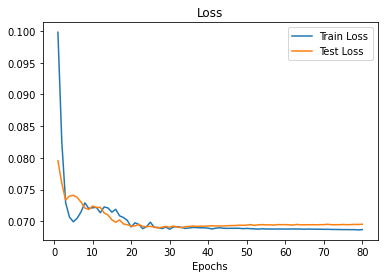

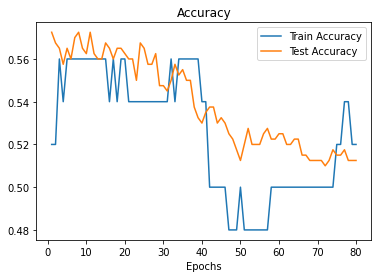

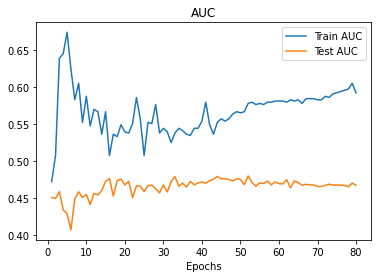

Train pass no. 2
Train pass no. 3
Train pass no. 4
Train pass no. 5
Train pass no. 6
Train pass no. 7
Train pass no. 8


{'testAUC': 0.4942056704879975,
 'testAccuracy': 0.528125,
 'testLoss': 0.06918332353234291,
 'trainAUC': 0.5370850629611333,
 'trainAccuracy': 0.54,
 'trainLoss': 0.06786772981286049,
 'tuneLoss': 0.08493065740913153}

In [22]:
# Note, with 10 runs, 100 epochs and 20 tuning iterations this can take up to 2 hrs
params['num_run'] = 8
params['num_epochs'] = 80
params['num_tune_iters'] = 20
params['fine_tune'] = False  # Flag for launching fine tuning or subnetwork search

best_config = launch_tune().get_best_config(metric='mean_loss', mode='min')
print('Parameters and best hyperparameters')
print(params, best_config)
multi_runs(best_config, None)

### Fine tune QNet and get scores

Trial name,ID,status,loc,decay,lr,k,iter,total time (s),loss
multi_runs_d8afb1a2,d8afb1a2,TERMINATED,pid=10524,0.0209094,0.00101132,1,8,74.5082,0.0843313
multi_runs_d904ff0e,d904ff0e,TERMINATED,pid=10562,0.0151864,0.0101415,1,1,12.1444,0.277776
multi_runs_d95e2818,d95e2818,TERMINATED,pid=10585,0.00939438,0.04028,1,1,12.0818,0.314955
multi_runs_d9b67068,d9b67068,TERMINATED,pid=10605,0.026987,0.0688367,1,4,38.0256,0.0822407
multi_runs_da1324ca,da1324ca,TERMINATED,pid=10634,0.0103022,0.00371137,1,8,75.3922,0.107508
multi_runs_da683bcc,da683bcc,TERMINATED,pid=10675,0.0335563,0.0563103,1,1,12.2407,0.0737101
multi_runs_dabf3512,dabf3512,TERMINATED,pid=10698,0.00710531,0.0802737,1,1,12.3079,0.0805706
multi_runs_db18f926,db18f926,TERMINATED,pid=10718,0.0484163,0.0695399,1,1,12.2091,0.0875581
multi_runs_db71777c,db71777c,TERMINATED,pid=10741,0.0438318,0.00941938,1,1,12.0599,0.189381
multi_runs_dbcb1a70,dbcb1a70,TERMINATED,pid=10764,0.00204883,0.0879361,1,1,12.4088,0.0835059


2020-05-20 14:06:28,011	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


Parameters and best hyperparameters
{'num_train': 50, 'num_tune': 25, 'num_val': 400, 'batch_size': 10, 'val_batch_size': 10, 'num_epochs': 80, 'use_qnet_weights': True, 'use_mnist': False, 'num_run': 8, 'num_tune_iters': 20, 'fine_tune': True} {'decay': 0.020909398034658442, 'k': 1.0, 'lr': 0.0010113231069171437}
Train pass no. 1
Debug charts for first training run


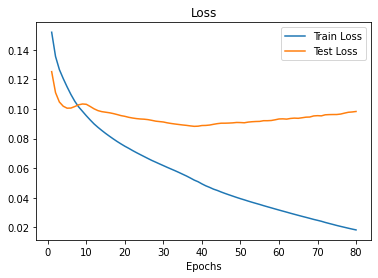

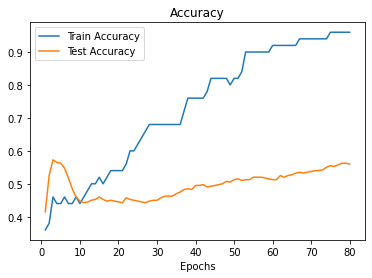

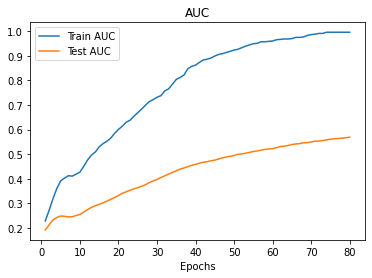

Train pass no. 2
Train pass no. 3
Train pass no. 4
Train pass no. 5
Train pass no. 6
Train pass no. 7
Train pass no. 8


{'testAUC': 0.7526192044280675,
 'testAccuracy': 0.6753124999999999,
 'testLoss': 0.08198010502383113,
 'trainAUC': 0.9881477601972823,
 'trainAccuracy': 0.9275,
 'trainLoss': 0.01756629382725805,
 'tuneLoss': 0.11549601936712861}

In [23]:
# Note, with 10 runs, 100 epochs and 20 tuning iterations this can take up to 2 hrs
params['fine_tune'] = True  # Flag for launching fine tuning or subnetwork search

best_config = launch_tune().get_best_config(metric='mean_loss', mode='min')
print('Parameters and best hyperparameters')
print(params, best_config)
multi_runs(best_config, None)